In [10]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def calculateEpsilons(eigenVals, eigenVects, M): # only works for 2 agents
    eps_n = np.sqrt(M) * np.sum((np.abs(eigenVals[1:]) / (1 - np.abs(eigenVals[1:]))))
    vpos = 0
    vneg = 0
    b = 0
    eps_c = 0
    for i in range(M):
        if((eigenVects * np.transpose(eigenVects))[i,i] >= 0):
            vpos = np.sum(eigenVects[i,0] * eigenVects[i,1])
        if((eigenVects * np.transpose(eigenVects))[i,i] <= 0):
            vneg = np.sum(eigenVects[i,0] * eigenVects[i,1])
    
        if(eigenVals[0] * eigenVals[1] >= 0 and (eigenVects * np.transpose(eigenVects))[i,i] >= 0):
            b = vpos * (eigenVects * (np.transpose(eigenVects)))[i,i]
        elif(eigenVals[0] * eigenVals[1] >= 0 and (eigenVects * np.transpose(eigenVects))[i,i] <= 0):
            b = vneg * (eigenVects * (np.transpose(eigenVects)))[i,i]
        else:
            b = max(np.abs(vneg), vpos) * np.abs((eigenVects * np.transpose(eigenVects))[i,i])
    
    for p in range(M - 1):
        lambdas = np.abs(eigenVals[p] * eigenVals[p+1])
        eps_c += (lambdas / (1 - lambdas)) * b
    eps_c *= M
    return eps_n, eps_c

In [12]:
class Agent:
    def __init__(self, num_arms):
        # Number of total steps
        self.total_arm_selections = np.ones(num_arms)
        # Total reward for each arm
        self.arm_rewards = np.zeros(num_arms)
        # Total mean reward from all arms
        self.mean_rewards = self.arm_rewards / self.total_arm_selections
    
    def updateSelections(self, index):
        self.total_arm_selections[index] += 1
    
    def updateRewards(self, index, reward):
        self.arm_rewards[index] = reward
    
    def updateMeans(self):
        self.mean_rewards = self.arm_rewards / self.total_arm_selections

In [13]:
class Arm:
    def __init__(self):
        self.reward_distrib = np.random.normal(0, 1)
    
    def getReward(self):
        return np.random.normal(self.reward_distrib, 1)

In [210]:
N = 5 # number of arms
M = 2 # number of agents
arms = []
agents = []
arm_selections = []
arm_rewards = []
mean_rewards = []

indicators = np.zeros([M,N])
rewards = np.zeros([M,N])

T = 500 # time to run for
gamma = 1.2 # must be greater than 1 according to paper

for i in range(N): # initialize arms
    arms.append(Arm())

for i in range(M): # initialize agents
    agents.append(Agent(N))

for i in range(len(agents)): # get arrays of selections and rewards
    arm_selections.append(agents[i].total_arm_selections)
    arm_rewards.append(agents[i].arm_rewards)
arm_selections = np.array(arm_selections)
arm_rewards = np.array(arm_rewards)

for i in range(len(arms)): # initialize with 1 round of rewards
    for j in range(len(agents)):
        reward = arms[i].getReward()
        arm_rewards[j][i] = reward
mean_rewards = arm_rewards/arm_selections

In [211]:
G = nx.Graph()
G.add_nodes_from([0, 1])
G.add_edges_from([(0, 1)])
A = nx.adjacency_matrix(G)
L = nx.laplacian_matrix(G)

M = len(G)

maxDeg = 0
for i in range(len(G)): # find max degree in graph
    if G.degree[i] > maxDeg:
        maxDeg = G.degree[i]

kappa = .2
P = np.eye(len(G)) - (kappa*L / maxDeg) # calculate P matrix from paper
eigenVals, eigenVects = np.linalg.eig(P) # calculate P's eigenvectors and eigenvalues

_, eps_c = calculateEpsilons(eigenVals, eigenVects, M) # calculate epsilons eps_n and eps_c from paper

In [212]:
reward = 0
sampledIndex = 0
maxRwd = 0
maxIndex = 0
sampledIndices = []
iter_rewards = np.zeros(T+1)
meanRwd = 0

for t in range(1,T+1):
    mean_rewards = arm_rewards/arm_selections # update u_i(t)
    arm_selections = P*arm_selections + P*indicators # update s_i(t)
    arm_rewards = P*arm_rewards + P*rewards # update n_i(t)
    indicators = np.zeros([M,N])
    rewards = np.zeros([M,N])
    for k in range(len(agents)):
        maxRwd = 0
        vals = []
        for i in range(len(arms)): # loop through arms to find max reward to decide which arm to choose
            val = mean_rewards[k,i] + np.sqrt((2*gamma) * ((arm_selections[k,i] + eps_c) / (M*arm_selections[k,i])) * (np.log(t)/arm_selections[k,i]))
            vals.append(val)
            if val > maxRwd:
                maxRwd = val
                maxIndex = i
        sampledIndex = maxIndex # set index of chosen arm
        sampledIndices.append(sampledIndex)
        reward = arms[sampledIndex].getReward() # get reward from chosen arm
        meanRwd = meanRwd + (reward-meanRwd) / t
        indicators[k,sampledIndex] = 1 # set indicator to 1 for chosen arm
        rewards[k,sampledIndex] = reward # set r_i(t)
        iter_rewards[t] = meanRwd

In [213]:
mean_rewards

matrix([[-0.99265353,  0.3371351 , -0.77040474,  1.98434726, -0.8639021 ],
        [-0.99265353,  0.3371351 , -0.77040474,  1.98407751, -0.8639021 ]])

In [214]:
arm_selections

matrix([[  2. ,   4. ,   2.5, 493.5,   2. ],
        [  2. ,   4. ,   2.5, 493.5,   2. ]])

In [215]:
arm_rewards

matrix([[ -1.98530705,   1.34854041,  -1.92601186, 978.56463474,
          -1.7278042 ],
        [ -1.98530705,   1.34854041,  -1.92601186, 978.38544372,
          -1.7278042 ]])

In [216]:
for arm in arms:
    print(arm.reward_distrib)

-0.9328644316634388
0.13379718073227406
-0.8860113685749621
2.045268497257454
-0.3669392639235311


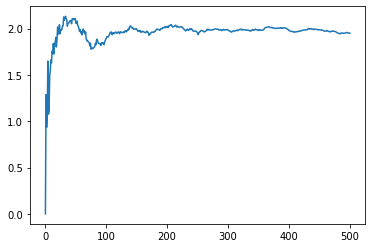

In [217]:
plt.plot(range(T+1), iter_rewards)